# Random Forest Classifier

This script contains code for RF classification, which we run on constructed + given combined features file to obtain benchmark results. We will use these benchmark results to compare the performance of our NN. We experimented with running the RF classifier on both the unbalanced (before SMOTE) and balanced (after SMOTE) datasets, using different numbers of estimators (`n_estimators`) and different numbers of jobs (`n_jobs`) to find the best solution.

In [2]:
#import the necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [3]:
data_dir = '/home/shoaib/PSChallenge/'

First, we load the constructed and given light curve features and merge the two to obtain a complete dataframe with all the features of each object. We choose only the objects of Q, QR and QX types which will be used for classification, create a numerical property to indicate which of these three classes each object belongs to, and remove Nan values.

In [12]:
original_features = pd.read_csv(data_dir + 'gr_features_by_object.csv')
new_features = pd.read_csv(data_dir + 'new_features.csv')

#merge all features into one df
features = original_features.merge(new_features, on='name', how='inner')

del original_features
del new_features

We remove other types which are not Q, QX, QR.

In [13]:
features = features[features['type'].isin(['Q', 'QR', 'QX'])]

In [ ]:
# check for Nan values

# Calculate the number of NaN values for each column
nan_counts = features.isna().sum()

# Create a DataFrame to display column names and their NaN counts
nan_info = pd.DataFrame({
    'Column Name': nan_counts.index,
    'NaN Count': nan_counts.values
})

#Display the table
print(nan_info)

          Column Name  NaN Count
0                name          0
1      avg_good_det_g          0
2        mhps_ratio_g          0
3          mhps_low_g          0
4         mhps_high_g          0
..                ...        ...
112           f_var_g         43
113           f_var_r        945
114       color_index          0
115          peak_lag          0
116  peak_correlation          0

[117 rows x 2 columns]


In [37]:
#remove Nan values and reprint Nan counts
sample1_num_nonan = features.dropna(subset=["f_var_r", "f_var_g", "mhps_high_r", "mhps_ratio_r"])

In [38]:
# Calculate the number of NaN values for each column
nan_counts = sample1_num_nonan.isna().sum()

# Create a DataFrame to display column names and their NaN counts
nan_info = pd.DataFrame({
    'Column Name': nan_counts.index,
    'NaN Count': nan_counts.values
})

# Display the table
print(nan_info)

             Column Name  NaN Count
0                   name          0
1         avg_good_det_g          0
2           mhps_ratio_g          0
3             mhps_low_g          0
4            mhps_high_g          0
5        mhps_non_zero_g          0
6         mhps_PN_flag_g          0
7            Amplitude_g          0
8      AndersonDarling_g          0
9       Autocor_length_g          0
10          Beyond1Std_g          0
11                 Con_g          0
12               Eta_e_g          0
13               Gskew_g          0
14            MaxSlope_g          0
15                Mean_g          0
16        Meanvariance_g          0
17        MedianAbsDev_g          0
18           MedianBRP_g          0
19      PairSlopeTrend_g          0
20    PercentAmplitude_g          0
21                 Q31_g          0
22         PeriodLS_v2_g          0
23       Period_fit_v2_g          0
24           Psi_CS_v2_g          0
25          Psi_eta_v2_g          0
26                 Rcs_g    

Now we have no `Nan` values.

Next, we map each `type` to an `int` to convert to numerical values which can be used in the classifier.

In [39]:
numtype_map = {'Q': 0, 'QR': 1, 'QX': 2}
sample1_num_nonan['type'] = sample1_num_nonan['type'].replace(numtype_map)

sample1_num_nonan['type']

/tmp/ipykernel_13644/4201746685.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample1_num_nonan['type'] = sample1_num_nonan['type'].replace(numtype_map)


40       2
41       2
43       2
44       2
46       2
48       2
49       2
51       2
53       2
57       2
58       0
89       1
115      1
122      1
133      2
146      0
149      1
151      2
152      2
163      0
164      0
165      2
166      0
167      2
168      0
169      0
170      2
175      2
176      0
177      1
179      0
181      0
183      0
184      0
185      0
186      0
187      0
189      0
190      0
193      0
195      0
196      0
198      0
200      0
201      0
202      0
203      0
205      0
206      0
207      0
209      0
212      0
213      0
214      0
215      0
217      0
219      0
220      0
221      2
226      1
227      0
228      0
229      0
230      0
231      2
232      0
233      0
234      0
235      2
236      0
237      0
238      1
239      0
240      0
241      0
242      0
243      2
248      0
249      0
251      0
252      2
253      2
254      0
255      0
256      0
257      0
258      0
259      0
262      0
263      0
264      0

The column `type` is now of numerical format.

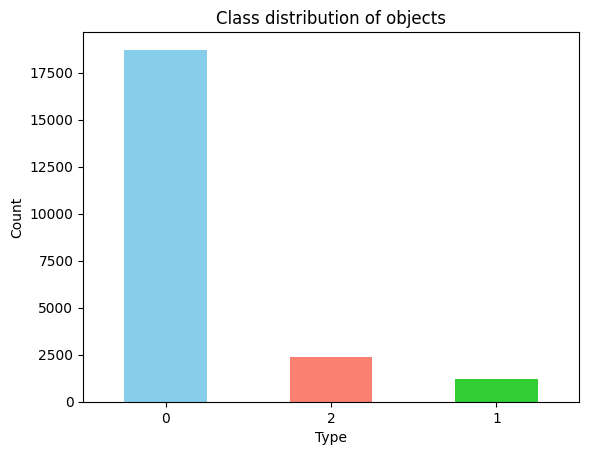

In [40]:
# Plot the class distribution
sample1_num_nonan['type'].value_counts().plot(kind='bar', color=['skyblue', 'salmon', 'limegreen'])
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Class distribution of objects')
plt.xticks(rotation=0)
plt.show()

In [41]:
# remove all other non-numerical type columns

sample1_num_nonan.drop(['name'], axis=1, inplace=True)

/tmp/ipykernel_13644/3733308884.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample1_num_nonan.drop(['name'], axis=1, inplace=True)


In [42]:
#check effects: Display data types of all columns
#print(sample1_num_nonan.dtypes)

# Filter and display columns that are NOT of dtype float64 or int64
non_numeric_dtypes = sample1_num_nonan.dtypes[~sample1_num_nonan.dtypes.isin(['float64', 'int64'])]
print(non_numeric_dtypes)

Series([], dtype: object)


Now, all columns are of numerical type and can be fed into the classifier.

# Random Forest Classifier

In [43]:
# removing the class attribute from X data array
X = sample1_num_nonan.drop(['type'], axis=1)

# storing labels for later
y = sample1_num_nonan['type']
display(X.shape, y.shape)
display(X.describe())

(22319, 115)

(22319,)

,avg_good_det_g,mhps_ratio_g,mhps_low_g,mhps_high_g,mhps_non_zero_g,mhps_PN_flag_g,Amplitude_g,AndersonDarling_g,Autocor_length_g,Beyond1Std_g,Con_g,Eta_e_g,Gskew_g,MaxSlope_g,Mean_g,Meanvariance_g,MedianAbsDev_g,MedianBRP_g,PairSlopeTrend_g,PercentAmplitude_g,Q31_g,PeriodLS_v2_g,Period_fit_v2_g,Psi_CS_v2_g,Psi_eta_v2_g,Rcs_g,Skew_g,SmallKurtosis_g,Std_g,StetsonK_g,Pvar_g,ExcessVar_g,GP_DRW_sigma_g,GP_DRW_tau_g,SF_ML_amplitude_g,SF_ML_gamma_g,IAR_phi_g,LinearTrend_g,Harmonics_mag_1_g,Harmonics_mag_2_g,Harmonics_mag_3_g,Harmonics_mag_4_g,Harmonics_mag_5_g,Harmonics_mag_6_g,Harmonics_mag_7_g,Harmonics_phase_2_g,Harmonics_phase_3_g,Harmonics_phase_4_g,Harmonics_phase_5_g,Harmonics_phase_6_g,Harmonics_phase_7_g,Harmonics_mse_g,avg_good_det_r,mhps_ratio_r,mhps_low_r,mhps_high_r,mhps_non_zero_r,mhps_PN_flag_r,Amplitude_r,AndersonDarling_r,Autocor_length_r,Beyond1Std_r,Con_r,Eta_e_r,Gskew_r,MaxSlope_r,Mean_r,Meanvariance_r,MedianAbsDev_r,MedianBRP_r,PairSlopeTrend_r,PercentAmplitude_r,Q31_r,PeriodLS_v2_r,Period_fit_v2_r,Psi_CS_v2_r,Psi_eta_v2_r,Rcs_r,Skew_r,SmallKurtosis_r,Std_r,StetsonK_r,Pvar_r,ExcessVar_r,GP_DRW_sigma_r,GP_DRW_tau_r,SF_ML_amplitude_r,SF_ML_gamma_r,IAR_phi_r,LinearTrend_r,Harmonics_mag_1_r,Harmonics_mag_2_r,Harmonics_mag_3_r,Harmonics_mag_4_r,Harmonics_mag_5_r,Harmonics_mag_6_r,Harmonics_mag_7_r,Harmonics_phase_2_r,Harmonics_phase_3_r,Harmonics_phase_4_r,Harmonics_phase_5_r,Harmonics_phase_6_r,Harmonics_phase_7_r,Harmonics_mse_r,rms_g,rms_r,amplitude_g,amplitude_r,mag_std_g,mag_std_r,f_var_g,f_var_r,color_index,peak_lag,peak_correlation
count,22319.000000,2.231900e+04,22319.000000,2.231900e+04,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,2.231900e+04,2.231900e+04,22319.000000,22319.000000,2.231900e+04,22319.000000,2.231900e+04,2.231900e+04,2.231900e+04,2.231900e+04,2.231900e+04,2.231900e+04,2.231900e+04,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,2.231900e+04,22319.000000,2.231900e+04,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,2.231900e+04,2.231900e+04,22319.000000,22319.000000,2.231900e+04,22319.000000,2.231900e+04,2.231900e+04,2.231900e+04,2.231900e+04,2.231900e+04,2.231900e+04,2.231900e+04,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,2.231900e+04,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000
mean,346.688328,3.118277e+09,0.133769,1.635664e-02,340.107871,0.078827,0.291293,0.939765,17.306949,0.299247,0.002898,0.785788,-0.028724,306.634225,19.558374,0.007682,0.095772,0.510188,-0.002303,0.028774,0.195768,42.714957,0.056501,0.180088,1.258726,0.267353,-0.208884,1.380659,0.151670,0.766975,0.994726,0.000038,2.301810e-02,2.278960e+02,0.177099,0.300498,9.608235e-01,0.000032,2.666373e+06,2.405511e+06,2.411393e+06,1.548847e+06,9.135754e+05,6.202349e+05,1.954613e+05,3.151908,3.158545,3.111300,3.134366,3.127490,3.129155,0.015211,378.697717,4.850492e+08,0.098684,1.679221e-02,372.437014,0.212610,0.242456,0.922994,18.854900,0.298913,0.002873,0.958227,0.000935,315.325327,19.345355,0.006502,0.081322,0.509316,-0.000005,0.024455,0.166031,37.851774,0.062924,0.180123,1.258458,0.265952,-0.081379,1.555351,0.127172,0.776196,0.985071,0.000025,1.617047e-02,3.563543e+02,0.213399,0.519976,9.603419e-01,0.000016,1.552753e+06,1.207

* First Split: train_test_split splits the data into 80% training (X_train, y_train) and 20% temporary set (X_temp, y_temp).
stratify=y ensures class distribution is preserved.
* Second Split:
The temporary set (X_temp, y_temp) is split into 50% validation and 50% test sets, so we get:
    * 80% Training → X_train, y_train
    * 10% Validation → X_val, y_val
    * 10% Test → X_test, y_test

In [44]:
# split our data into 80% training, 10% validation, 10% test

X_train, X_temp, y_train, y_temp = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = model_selection.train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [45]:
#apply standard scalar

## standardization using StandardScaler applied to X_train (yields mean and sigma for X_train)
## and then standardizing X_train and X_test and X_unlab with mean and sigma obtained from X_train
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

display(X_train.shape, X_test.shape)

(17855, 115)

(2232, 115)

Note the following parameters when training the RF classifier:
- `n_estimators` specifies the number of trees in the forest.
    - **Effect:** Increasing the number of trees can improve the model's performance because it allows more trees to "vote" on each classification, reducing the variance and generally improving accuracy.
    - **Optimal Value:** The best value depends on the dataset size and computational resources. Higher values (like 500, 1000, or even 2000) are typically beneficial, but there are diminishing returns as you add more trees, especially if the model's performance plateaus. Values between 100 and 500 are often effective in practice, but in some cases, larger values (1000+) yield small improvements.
- `n_jobs` specifies the number of CPU cores to use in the training the model. Setting `n_jobs=-1` uses all available cores, so we adopt this setting to dynamically adapt to the available cores automatically.
    - **Effect:** Increasing n_jobs can significantly reduce training time by allowing multiple trees to be built in parallel.
    - **Optimal Value:** Set n_jobs=-1 to use all available cores unless you need to reserve some CPU resources for other tasks. In your case, setting n_jobs=70 would use 70 cores if your machine supports it, which can speed up training.

**Practical considerations**
- Model Performance: Test a few values of n_estimators and observe accuracy improvements; if increasing n_estimators beyond a certain threshold yields minimal gains, stop there.

In [ ]:
# create random forest classifier

clf=RandomForestClassifier(n_estimators=2000, n_jobs=70, criterion="entropy")

#Train the model using the training sets
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=2000, n_jobs=70)

In [ ]:
#display results in confusion matrix



Next, we divide the X (features) data which will be used for classification, and the true classes y (type).

In [8]:
# Step 1: Separate features and labels
X = sample1_num_nonan.drop(columns=['type'])
y = sample1_num_nonan['type']

# Step 2: Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Step 3: Convert the resampled data back to a DataFrame
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled_df = pd.DataFrame(y_resampled, columns=['numtype'])

# Combine the resampled features and labels into one balanced DataFrame
balanced_df = pd.concat([X_resampled_df, y_resampled_df], axis=1)

# Display the new class distribution
print(balanced_df['numtype'].value_counts())

# Optional: Plot the new balanced class distribution
balanced_df['numtype'].value_counts().plot(kind='bar', color=['skyblue', 'salmon', 'limegreen'])
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Balanced Histogram of Each QSO Type after SMOTE')
plt.xticks(rotation=0)
plt.show()

NameError: name 'sample1_num_nonan' is not defined

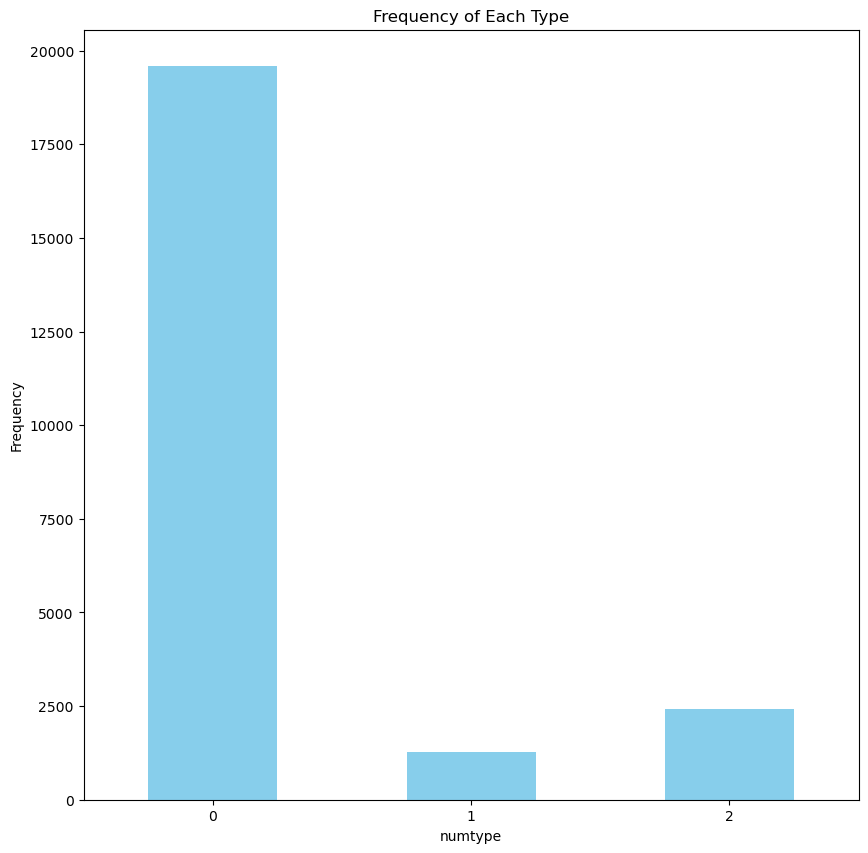

In [9]:
# Calculate the frequency of each value in 'numtype'
numtype_counts = qso_select_df['numtype'].value_counts().sort_index()

# Plot a bar chart of the frequencies
plt.figure(figsize=(10, 10))
numtype_counts.plot.bar(color='skyblue')
plt.title('Frequency of Each Type')
plt.xlabel('numtype')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [10]:
# ONLY we need numerical values

#drop all object-type columns
sample1_num = qso_select_df.drop(['name', 'type'], axis=1)

In [11]:
# removing Nan values

# Calculate the number of NaN values for each column
nan_counts = sample1_num.isna().sum()

# Create a DataFrame to display column names and their NaN counts
nan_info = pd.DataFrame({
    'Column Name': nan_counts.index,
    'NaN Count': nan_counts.values
})

# Display the table
#print(nan_info)

In [13]:
# removing Nan values

# Calculate the number of NaN values for each column
nan_counts = sample1_num_nonan.isna().sum()

# Create a DataFrame to display column names and their NaN counts
nan_info = pd.DataFrame({
    'Column Name': nan_counts.index,
    'NaN Count': nan_counts.values
})

# Display the table
#print(nan_info)

In [14]:
X = sample1_num_nonan
# removing the class attribute from X data array
X = X.drop(['numtype'], axis=1)

# storing labels for later
y = sample1_num_nonan['numtype']
display(X.shape, y.shape)
display(X.describe())

(22319, 115)

(22319,)

,rms_g,rms_r,amplitude_g,amplitude_r,mag_std_g,mag_std_r,f_var_g,f_var_r,color_index,peak_lag,peak_correlation,avg_good_det_g,mhps_ratio_g,mhps_low_g,mhps_high_g,mhps_non_zero_g,mhps_PN_flag_g,Amplitude_g,AndersonDarling_g,Autocor_length_g,Beyond1Std_g,Con_g,Eta_e_g,Gskew_g,MaxSlope_g,Mean_g,Meanvariance_g,MedianAbsDev_g,MedianBRP_g,PairSlopeTrend_g,PercentAmplitude_g,Q31_g,PeriodLS_v2_g,Period_fit_v2_g,Psi_CS_v2_g,Psi_eta_v2_g,Rcs_g,Skew_g,SmallKurtosis_g,Std_g,StetsonK_g,Pvar_g,ExcessVar_g,GP_DRW_sigma_g,GP_DRW_tau_g,SF_ML_amplitude_g,SF_ML_gamma_g,IAR_phi_g,LinearTrend_g,Harmonics_mag_1_g,Harmonics_mag_2_g,Harmonics_mag_3_g,Harmonics_mag_4_g,Harmonics_mag_5_g,Harmonics_mag_6_g,Harmonics_mag_7_g,Harmonics_phase_2_g,Harmonics_phase_3_g,Harmonics_phase_4_g,Harmonics_phase_5_g,Harmonics_phase_6_g,Harmonics_phase_7_g,Harmonics_mse_g,avg_good_det_r,mhps_ratio_r,mhps_low_r,mhps_high_r,mhps_non_zero_r,mhps_PN_flag_r,Amplitude_r,AndersonDarling_r,Autocor_length_r,Beyond1Std_r,Con_r,Eta_e_r,Gskew_r,MaxSlope_r,Mean_r,Meanvariance_r,MedianAbsDev_r,MedianBRP_r,PairSlopeTrend_r,PercentAmplitude_r,Q31_r,PeriodLS_v2_r,Period_fit_v2_r,Psi_CS_v2_r,Psi_eta_v2_r,Rcs_r,Skew_r,SmallKurtosis_r,Std_r,StetsonK_r,Pvar_r,ExcessVar_r,GP_DRW_sigma_r,GP_DRW_tau_r,SF_ML_amplitude_r,SF_ML_gamma_r,IAR_phi_r,LinearTrend_r,Harmonics_mag_1_r,Harmonics_mag_2_r,Harmonics_mag_3_r,Harmonics_mag_4_r,Harmonics_mag_5_r,Harmonics_mag_6_r,Harmonics_mag_7_r,Harmonics_phase_2_r,Harmonics_phase_3_r,Harmonics_phase_4_r,Harmonics_phase_5_r,Harmonics_phase_6_r,Harmonics_phase_7_r,Harmonics_mse_r
count,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,2.231900e+04,22319.000000,2.231900e+04,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,2.231900e+04,2.231900e+04,22319.000000,22319.000000,2.231900e+04,22319.000000,2.231900e+04,2.231900e+04,2.231900e+04,2.231900e+04,2.231900e+04,2.231900e+04,2.231900e+04,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,2.231900e+04,22319.000000,2.231900e+04,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,2.231900e+04,2.231900e+04,22319.000000,22319.000000,2.231900e+04,22319.000000,2.231900e+04,2.231900e+04,2.231900e+04,2.231900e+04,2.231900e+04,2.231900e+04,2.231900e+04,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,2.231900e+04
mean,0.157778,0.130145,0.989430,0.846642,0.152678,0.128099,0.005573,0.004358,0.213013,-0.218513,5.890042,346.688328,3.118277e+09,0.133769,1.635664e-02,340.107871,0.078827,0.291293,0.939765,17.306949,0.299247,0.002898,0.785788,-0.028724,306.634225,19.558374,0.007682,0.095772,0.510188,-0.002303,0.028774,0.195768,42.714957,0.056501,0.180088,1.258726,0.267353,-0.208884,1.380659,0.151670,0.766975,0.994726,0.000038,2.301810e-02,2.278960e+02,0.177099,0.300498,9.608235e-01,0.000032,2.666373e+06,2.405511e+06,2.411393e+06,1.548847e+06,9.135754e+05,6.202349e+05,1.954613e+05,3.151908,3.158545,3.111300,3.134366,3.127490,3.129155,0.015211,378.697717,4.850492e+08,0.098684,1.679221e-02,372.437014,0.212610,0.242456,0.922994,18.854900,0.298913,0.002873,0.958227,0.000935,315.325327,19.345355,0.006502,0.081322,0.509316,-0.000005,0.024455,0.166031,37.851774,0.062924,0.180123,1.258458,0.265952,-0.081379,1.555351,0.127172,0.776196,0.

# Using oversampling to fix imbalance

SMOTE (synthetic minority oversampling technique) is one of the most commonly used oversampling methods to solve the imbalance problem. It aims to balance class distribution by randomly increasing minority class examples by replicating them. SMOTE synthesises new minority instances between existing minority instances.

In [15]:
from imblearn.over_sampling import SMOTE

numtype
0    18722
1    18722
2    18722
Name: count, dtype: int64


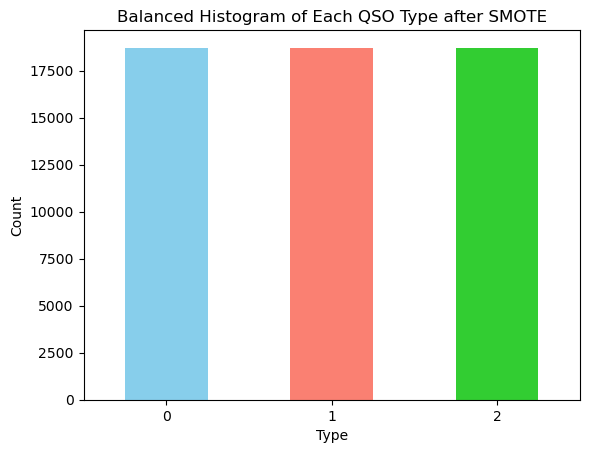

In [16]:
# Step 1: Separate features and labels
X = sample1_num_nonan.drop(columns=['numtype'])
y = sample1_num_nonan['numtype']

# Step 2: Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Step 3: Convert the resampled data back to a DataFrame
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled_df = pd.DataFrame(y_resampled, columns=['numtype'])

# Combine the resampled features and labels into one balanced DataFrame
balanced_df = pd.concat([X_resampled_df, y_resampled_df], axis=1)

# Display the new class distribution
print(balanced_df['numtype'].value_counts())

# Optional: Plot the new balanced class distribution
balanced_df['numtype'].value_counts().plot(kind='bar', color=['skyblue', 'salmon', 'limegreen'])
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Balanced Histogram of Each QSO Type after SMOTE')
plt.xticks(rotation=0)
plt.show()

# Data preprocessing

All data types are numerical (float or integer)

In [18]:
X = balanced_df
# removing the class attribute from X data array
X = X.drop(['numtype'], axis=1)

# storing labels for later
y = balanced_df['numtype']
display(X.shape, y.shape)
display(X.describe())

(56166, 115)

(56166,)

,rms_g,rms_r,amplitude_g,amplitude_r,mag_std_g,mag_std_r,f_var_g,f_var_r,color_index,peak_lag,peak_correlation,avg_good_det_g,mhps_ratio_g,mhps_low_g,mhps_high_g,mhps_non_zero_g,mhps_PN_flag_g,Amplitude_g,AndersonDarling_g,Autocor_length_g,Beyond1Std_g,Con_g,Eta_e_g,Gskew_g,MaxSlope_g,Mean_g,Meanvariance_g,MedianAbsDev_g,MedianBRP_g,PairSlopeTrend_g,PercentAmplitude_g,Q31_g,PeriodLS_v2_g,Period_fit_v2_g,Psi_CS_v2_g,Psi_eta_v2_g,Rcs_g,Skew_g,SmallKurtosis_g,Std_g,StetsonK_g,Pvar_g,ExcessVar_g,GP_DRW_sigma_g,GP_DRW_tau_g,SF_ML_amplitude_g,SF_ML_gamma_g,IAR_phi_g,LinearTrend_g,Harmonics_mag_1_g,Harmonics_mag_2_g,Harmonics_mag_3_g,Harmonics_mag_4_g,Harmonics_mag_5_g,Harmonics_mag_6_g,Harmonics_mag_7_g,Harmonics_phase_2_g,Harmonics_phase_3_g,Harmonics_phase_4_g,Harmonics_phase_5_g,Harmonics_phase_6_g,Harmonics_phase_7_g,Harmonics_mse_g,avg_good_det_r,mhps_ratio_r,mhps_low_r,mhps_high_r,mhps_non_zero_r,mhps_PN_flag_r,Amplitude_r,AndersonDarling_r,Autocor_length_r,Beyond1Std_r,Con_r,Eta_e_r,Gskew_r,MaxSlope_r,Mean_r,Meanvariance_r,MedianAbsDev_r,MedianBRP_r,PairSlopeTrend_r,PercentAmplitude_r,Q31_r,PeriodLS_v2_r,Period_fit_v2_r,Psi_CS_v2_r,Psi_eta_v2_r,Rcs_r,Skew_r,SmallKurtosis_r,Std_r,StetsonK_r,Pvar_r,ExcessVar_r,GP_DRW_sigma_r,GP_DRW_tau_r,SF_ML_amplitude_r,SF_ML_gamma_r,IAR_phi_r,LinearTrend_r,Harmonics_mag_1_r,Harmonics_mag_2_r,Harmonics_mag_3_r,Harmonics_mag_4_r,Harmonics_mag_5_r,Harmonics_mag_6_r,Harmonics_mag_7_r,Harmonics_phase_2_r,Harmonics_phase_3_r,Harmonics_phase_4_r,Harmonics_phase_5_r,Harmonics_phase_6_r,Harmonics_phase_7_r,Harmonics_mse_r
count,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,5.616600e+04,56166.000000,5.616600e+04,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,5.616600e+04,5.616600e+04,56166.000000,56166.000000,5.616600e+04,56166.000000,5.616600e+04,5.616600e+04,5.616600e+04,5.616600e+04,5.616600e+04,5.616600e+04,5.616600e+04,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,5.616600e+04,56166.000000,5.616600e+04,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,5.616600e+04,5.616600e+04,56166.000000,56166.000000,5.616600e+04,56166.000000,5.616600e+04,5.616600e+04,5.616600e+04,5.616600e+04,5.616600e+04,5.616600e+04,5.616600e+04,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,56166.000000,5.616600e+04
mean,0.150716,0.123294,0.935994,0.790587,0.146764,0.122112,0.005565,0.004380,0.221884,-0.213403,5.966998,350.677827,1.247102e+09,0.104660,1.424758e-02,344.285559,0.083593,0.278017,0.946356,19.905988,0.301894,0.003375,0.738037,-0.022244,286.109110,19.377314,0.007441,0.092674,0.502234,-0.002706,0.027447,0.190451,42.479068,0.063073,0.185356,1.206085,0.276234,-0.177255,1.297299,0.145816,0.772663,0.994548,0.000039,2.276418e-02,2.806094e+02,0.178076,0.323895,9.623186e-01,0.000026,1.369757e+06,1.186572e+06,2.062208e+06,1.361230e+06,1.018880e+06,1.019106e+06,3.672878e+05,3.137115,3.123533,3.102981,3.127007,3.150298,3.113718,0.013665,380.805839,1.978175e+08,0.069584,1.136402e-02,374.733158,0.209525,0.229660,0.931199,21.543822,0.301545,0.003452,0.915151,0.003249,287.657532,19.155414,0.006250,0.077936,0.500783,-0.001482,0.023099,0.159949,37.155870,0.068910,0.185252,1.202172,0.275308,-0.062131,1.452893,0.121262,0.780933,0.

We are **splitting 80% training and 20% testing**.

In [19]:
X_train, X_temp, y_train, y_temp = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = model_selection.train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

## standardization using StandardScaler applied to X_train (yields mean and sigma for X_train)
## and then standardizing X_train and X_test and X_unlab with mean and sigma obtained from X_train
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
#X_unlab = scaler.transform(np.array(sample1_unlab))

display(X_train.shape, X_test.shape)#, X_unlab.shape)

(44932, 115)

(5617, 115)

# Random Forest Classifier



In [20]:
#for the sake of memory, empty out the dataframes we are no longer using
#del object_df
#del qso_df
#del qso_select_df
#del sample1_num
#del sample1_num_nonan

In [21]:
clf=RandomForestClassifier(n_estimators=2000, n_jobs=70, criterion="entropy")

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', n_estimators=2000, n_jobs=70)

In [22]:
y_val_pred = clf.predict(X_val)

print("Validation Set Performance:")
print(classification_report(y_val, y_val_pred))


Validation Set Performance:
              precision    recall  f1-score   support

           0       0.93      0.88      0.90      1872
           1       0.96      0.97      0.97      1872
           2       0.89      0.93      0.91      1873

    accuracy                           0.92      5617
   macro avg       0.93      0.92      0.92      5617
weighted avg       0.93      0.92      0.92      5617



In [23]:
y_pred_rf=clf.predict(X_test)

# Evaluate performance
print("Test Set Performance:")
print(classification_report(y_test, y_pred_rf))


Test Set Performance:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      1872
           1       0.96      0.97      0.96      1873
           2       0.90      0.93      0.91      1872

    accuracy                           0.93      5617
   macro avg       0.93      0.93      0.93      5617
weighted avg       0.93      0.93      0.93      5617



In [24]:

#y_unlab_rf = clf.predict(X_unlab)
#display(pd.DataFrame(y_unlab_rf).value_counts())
display(f"acc: {accuracy_score(y_test, y_pred_rf)}")

'acc: 0.9255830514509524'

In [25]:
str_labels = ['Q', 'QX', 'QR']

'accuracy score of:  0.9255830514509524'

'total number of class, number of missclasified objects (array([1872, 1872, 1873]), array([229,  61, 133]))'

'f1 score is:  [0.90273224 0.9625299  0.91104697]'

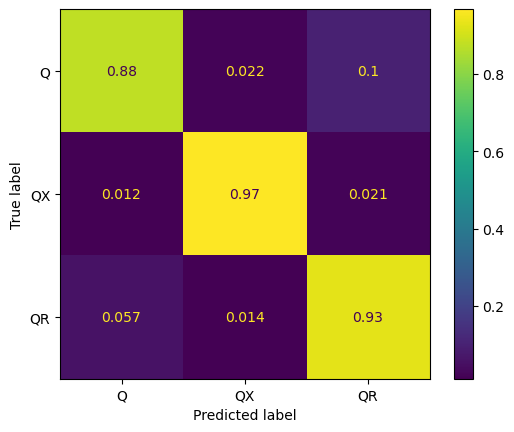

In [26]:
cf = confusion_matrix(y_val, y_val_pred)
cf_n = np.zeros(cf.shape)
labels_misscla_rf = np.array(np.sum(cf, axis=1) - np.diag(cf))
for i in range(cf.shape[0]):
    row_normalized = np.divide(cf[i, :], np.sum(cf[i, :]))
    cf_n[i, :] = row_normalized

ConfusionMatrixDisplay(cf_n, display_labels=str_labels).plot()
display(f"accuracy score of:  {accuracy_score(y_test, y_pred_rf)}")
display(f"total number of class, number of missclasified objects {np.sum(cf, axis=1),labels_misscla_rf.T}")
display(f"f1 score is:  {f1_score(y_test, y_pred_rf, average=None)}")

'accuracy score of:  0.9255830514509524'

'total number of class, number of missclasified objects (array([1872, 1873, 1872]), array([220,  62, 136]))'

'f1 score is:  [0.90273224 0.9625299  0.91104697]'

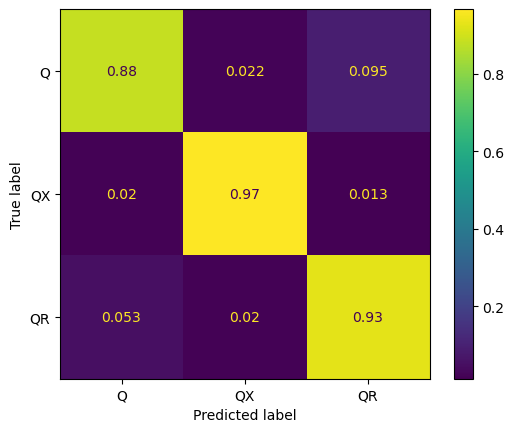

In [27]:
cf = confusion_matrix(y_test, y_pred_rf)
cf_n = np.zeros(cf.shape)
labels_misscla_rf = np.array(np.sum(cf, axis=1) - np.diag(cf))
for i in range(cf.shape[0]):
    row_normalized = np.divide(cf[i, :], np.sum(cf[i, :]))
    cf_n[i, :] = row_normalized

ConfusionMatrixDisplay(cf_n, display_labels=str_labels).plot()
display(f"accuracy score of:  {accuracy_score(y_test, y_pred_rf)}")
display(f"total number of class, number of missclasified objects {np.sum(cf, axis=1),labels_misscla_rf.T}")
display(f"f1 score is:  {f1_score(y_test, y_pred_rf, average=None)}")

### Changing SMOTE order

In [28]:
X = sample1_num_nonan.drop(columns=['numtype'])
y = sample1_num_nonan['numtype']

X_train, X_temp, y_train, y_temp = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = model_selection.train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

## standardization using StandardScaler applied to X_train (yields mean and sigma for X_train)
## and then standardizing X_train and X_test and X_unlab with mean and sigma obtained from X_train
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [29]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [30]:
clf=RandomForestClassifier(n_estimators=2000, n_jobs=70, criterion="entropy")

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=2000, n_jobs=70)

In [31]:
y_val_pred = clf.predict(X_val)

print("Validation Set Performance:")
print(classification_report(y_val, y_val_pred))


Validation Set Performance:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      1872
           1       0.13      0.02      0.04       122
           2       0.33      0.27      0.30       238

    accuracy                           0.81      2232
   macro avg       0.44      0.41      0.41      2232
weighted avg       0.76      0.81      0.78      2232



In [32]:
y_pred_rf=clf.predict(X_test)

# Evaluate performance
print("Test Set Performance:")
print(classification_report(y_test, y_pred_rf))


Test Set Performance:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1872
           1       0.17      0.04      0.07       123
           2       0.30      0.26      0.28       237

    accuracy                           0.80      2232
   macro avg       0.44      0.41      0.41      2232
weighted avg       0.76      0.80      0.78      2232



In [33]:

#y_unlab_rf = clf.predict(X_unlab)
#display(pd.DataFrame(y_unlab_rf).value_counts())
display(f"acc: {accuracy_score(y_test, y_pred_rf)}")

'acc: 0.7988351254480287'

'accuracy score of:  0.7988351254480287'

'total number of class, number of missclasified objects (array([1872,  122,  238]), array([140, 119, 173]))'

'f1 score is:  [0.88819876 0.06535948 0.27740492]'

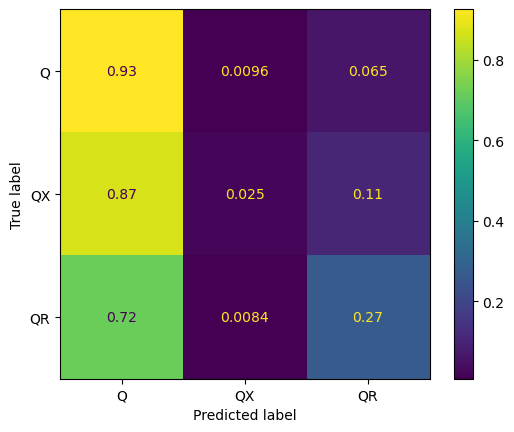

In [34]:
cf = confusion_matrix(y_val, y_val_pred)
cf_n = np.zeros(cf.shape)
labels_misscla_rf = np.array(np.sum(cf, axis=1) - np.diag(cf))
for i in range(cf.shape[0]):
    row_normalized = np.divide(cf[i, :], np.sum(cf[i, :]))
    cf_n[i, :] = row_normalized

ConfusionMatrixDisplay(cf_n, display_labels=str_labels).plot()
display(f"accuracy score of:  {accuracy_score(y_test, y_pred_rf)}")
display(f"total number of class, number of missclasified objects {np.sum(cf, axis=1),labels_misscla_rf.T}")
display(f"f1 score is:  {f1_score(y_test, y_pred_rf, average=None)}")

'accuracy score of:  0.7988351254480287'

'total number of class, number of missclasified objects (array([1872,  123,  237]), array([156, 118, 175]))'

'f1 score is:  [0.88819876 0.06535948 0.27740492]'

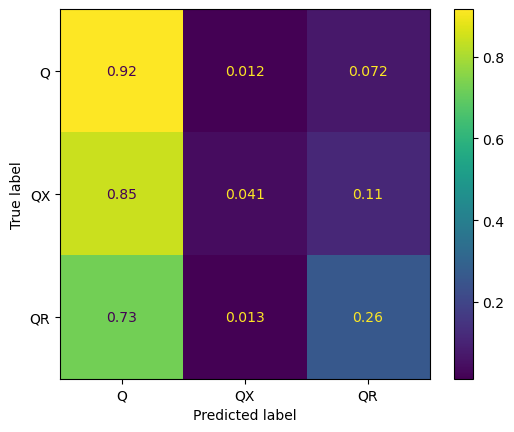

In [35]:
cf = confusion_matrix(y_test, y_pred_rf)
cf_n = np.zeros(cf.shape)
labels_misscla_rf = np.array(np.sum(cf, axis=1) - np.diag(cf))
for i in range(cf.shape[0]):
    row_normalized = np.divide(cf[i, :], np.sum(cf[i, :]))
    cf_n[i, :] = row_normalized

ConfusionMatrixDisplay(cf_n, display_labels=str_labels).plot()
display(f"accuracy score of:  {accuracy_score(y_test, y_pred_rf)}")
display(f"total number of class, number of missclasified objects {np.sum(cf, axis=1),labels_misscla_rf.T}")
display(f"f1 score is:  {f1_score(y_test, y_pred_rf, average=None)}")